In [13]:
import cv2
import numpy as np
#gray_image = cv2.imread(r"F:\Dataset\clear_dataset\2D_patch\2D_val_patch\2D_val_patch_tumor\DBT-P01150_DBT-S04884_lmlo_15.png", cv2.IMREAD_GRAYSCALE)
gray_image = cv2.imread(r"F:\Dataset\clear_dataset\2D_whole_image\2D_val\2D_val_tumor\DBT-P01150_DBT-S04884_lmlo_15.png", cv2.IMREAD_GRAYSCALE)
normalized_image = gray_image.astype(np.float32) / 255.0
normalized_image = (normalized_image * 255).astype(np.uint8)
rgb_image = cv2.applyColorMap(normalized_image, cv2.COLORMAP_JET)  # 使用伪彩色映射

hsv_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)

In [14]:
hue_shift = 30  # 调整色相
saturation_scale = 0.8  # 增加饱和度
value_scale = 15  # 增加明度

# 分离HSV通道
h, s, v = cv2.split(hsv_image)

# 调整色相（Hue）
h = (h + hue_shift) % 180  # OpenCV中Hue范围是[0, 179]

# 调整饱和度（Saturation）
s = np.clip(s * saturation_scale, 0, 255).astype(np.uint8)

# 调整明度（Value）
v = np.clip(v * value_scale, 0, 255).astype(np.uint8)

# 合并调整后的HSV通道
adjusted_hsv_image = cv2.merge([h, s, v])


Text(0.5, 1.0, 'hsv_image')

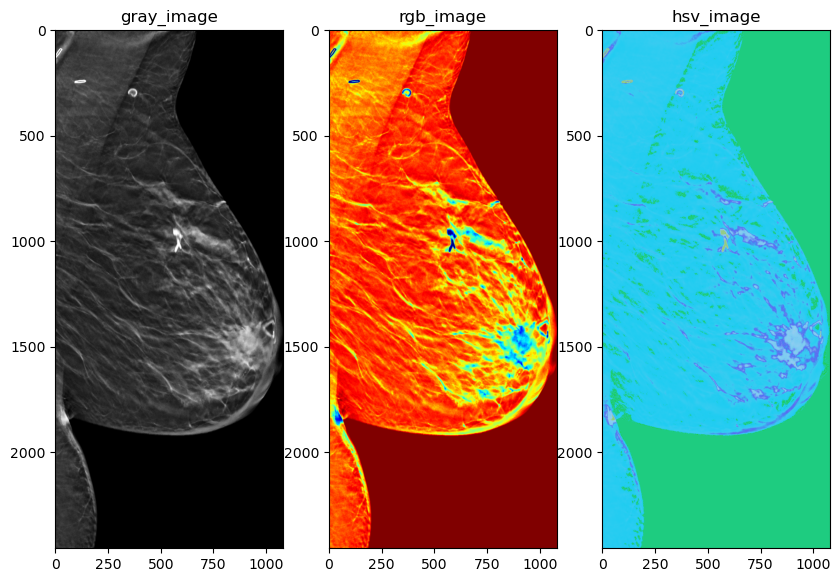

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(normalized_image, cmap='gray')
plt.title('gray_image')
plt.subplot(132)
plt.imshow(rgb_image)
plt.title('rgb_image')
plt.subplot(133)
plt.imshow(adjusted_hsv_image)
plt.title('hsv_image')

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torchvision
from torchvision import  transforms
from torch.utils.data import Dataset,DataLoader
from torchvision import models
import torch.optim as optim
from PIL import Image
import json
import os


In [5]:
import os
import json
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random

class CustomDataset(Dataset):
    def __init__(self, dataset_path, json_path, transform=None, augment_transform=None, n=2):
        self.dataset_path = dataset_path
        self.transform = transform
        self.augment_transform = augment_transform
        self.n = n

        with open(json_path, 'r') as f:
            self.labels = json.load(f)
        
        # 获取所有PNG图片的文件名
        self.image_files = [f for f in os.listdir(dataset_path) if f.endswith('.png')]
    
    def __len__(self):
        # 数据量扩大n倍
        return len(self.image_files) * self.n
    
    def _extract_prefix(self, filename):
        parts = filename.split('_')
        if len(parts) >= 3:
            prefix = '_'.join(parts[:3])
            view_char = parts[2]
            return prefix,view_char
        return filename  # 如果不足三个 '_'，返回原文件名
    
    def __getitem__(self, idx):
        original_idx = idx % len(self.image_files)

        img_name = self.image_files[original_idx]

        img_path = os.path.join(self.dataset_path, img_name)

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # 读取灰度图像

        img_prefix,view_char = self._extract_prefix(img_name)
        if view_char.lower().startswith('r'):
            image = cv2.flip(image, 1)  # 水平翻转图像

        normalized_image = image.astype(np.float32) / 255.0
        normalized_image = (normalized_image * 255).astype(np.uint8)    
        rgb_image = cv2.applyColorMap(normalized_image, cv2.COLORMAP_JET)

        rgb_image = Image.fromarray(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))

        label = -1  # 默认标签
        for key in self.labels:
            key_prefix,_ = self._extract_prefix(key)
            if key_prefix == img_prefix:
                label = self.labels[key]
                break
        if idx >= len(self.image_files) and self.augment_transform:
            # 对数据增强的样本应用增强变换
            rgb_image = self.augment_transform(rgb_image)
        elif self.transform:
            # 对原始样本应用默认变换
            rgb_image = self.transform(rgb_image)
        
        return rgb_image, label

In [16]:
dataset_path = r"F:\Dataset\Train_tumor\train_phase2\rgb_all_png\train_extend_DBT_slice_rgb_patch3"
json_path = r"F:\Dataset\clear_dataset\codes\codes_benign_malignant\file_benign_dict.json"


default_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整图片大小
    transforms.ToTensor(),          # 转换为Tensor
])

augment_transform = transforms.Compose([
    transforms.Resize((224, 224)),            # 调整图片大小
    transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转
    transforms.RandomRotation(10),           # 随机旋转
    #transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 随机调整亮度和对比度
    transforms.ToTensor(),                   # 转换为Tensor
])

dataset = CustomDataset(
    dataset_path=dataset_path,
    json_path=json_path,
    transform=default_transform,
    augment_transform=augment_transform,
    n=3
)

train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

val_dataset  = r"F:\Dataset\Val\val_phase2\rgb_all_png\val_extend_DBT_slice_rgb_patch3"
val_json = r"F:\Dataset\Val\results_val.json"

val_dataset =CustomDataset(
    dataset_path=val_dataset,
    json_path=val_json,
    transform=default_transform,
    augment_transform=augment_transform,
    n=2
)

val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class CombinedBinaryModel(nn.Module):
    def __init__(self, alpha=0.5, similarity_weight=0.1):
        super(CombinedBinaryModel, self).__init__()
        # Load ResNet18 model
        self.resnet18 = models.resnet18(pretrained=False)
        self.resnet18.fc = nn.Identity()  # Remove the final FC layer
        # Load AlexNet model
        self.alexnet = models.alexnet(pretrained=False)
        self.alexnet.classifier[6] = nn.Identity()  # Remove the final FC layer
        
        # Project both ResNet18 and AlexNet features to the same dimensionality
        self.resnet_projection = nn.Linear(512, 128)  # Project ResNet18 features to 128D
        self.alexnet_projection = nn.Linear(256, 128)  # Project AlexNet features to 128D
        
        # Apply adaptive average pooling to make feature maps the same size
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Pooling for both ResNet18 and AlexNet
        
        # Fully connected layer to combine ResNet18 and AlexNet features for binary classification
        self.fc = nn.Linear(512 + 256, 1)  # 512 (ResNet18) + 256 (AlexNet) = 768
        
        # Sigmoid activation for the final output
        self.sigmoid = nn.Sigmoid()
        
        # Similarity loss weight
        self.similarity_weight = similarity_weight

    def forward(self, x):
        # Get feature maps from ResNet18 and AlexNet
        resnet_features = self.resnet18(x)  # Output shape (batch_size, 512)
        alexnet_features = self.alexnet.features(x)  # Output shape (batch_size, 256, H, W)
        
        # Reshape ResNet18 features to have spatial dimensions (batch_size, 512, 1, 1)
        resnet_features = resnet_features.unsqueeze(-1).unsqueeze(-1)  # Shape: (batch_size, 512, 1, 1)
        
        # Apply global average pooling to both feature maps
        resnet_features = self.pool(resnet_features)  # Output shape (batch_size, 512, 1, 1)
        alexnet_features = self.pool(alexnet_features)  # Output shape (batch_size, 256, 1, 1)
        
        # Flatten the feature maps to vectors for similarity and concatenation
        resnet_features = resnet_features.view(resnet_features.size(0), -1)  # Shape: (batch_size, 512)
        alexnet_features = alexnet_features.view(alexnet_features.size(0), -1)  # Shape: (batch_size, 256)
        
        # Project both feature vectors to the same dimensionality
        resnet_projected = self.resnet_projection(resnet_features)  # Shape: (batch_size, 128)
        alexnet_projected = self.alexnet_projection(alexnet_features)  # Shape: (batch_size, 128)
        
        # Similarity loss (using MSE between the projected feature vectors)
        similarity_loss = F.mse_loss(resnet_projected, alexnet_projected)
        
        # Concatenate the features from ResNet18 and AlexNet
        combined_features = torch.cat((resnet_features, alexnet_features), dim=1)  # Shape: (batch_size, 768)
        
        # Apply fully connected layer for binary classification
        final_output = self.fc(combined_features)
        
        # Apply sigmoid activation
        final_output = self.sigmoid(final_output)
        
        return final_output, similarity_loss

# model = CombinedBinaryModel(alpha=0.7, similarity_weight=0.1)

# output, similarity_loss = model(input_tensor)
# # Suppose binary_labels is the ground truth binary labels (0 or 1)
# binary_labels = torch.randint(0, 2, (2, 1)).float()
# # Binary Cross Entropy loss
# bce_loss = F.binary_cross_entropy(output, binary_labels)
# # Final loss (binary cross-entropy loss + similarity loss)
# final_loss = bce_loss + similarity_loss * model.similarity_weight
# print(f"Final Loss: {final_loss.item()}")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score, matthews_corrcoef,
                             cohen_kappa_score, confusion_matrix, classification_report)
import numpy as np

def train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs=10):
    best_auc = 0.0  # 用于保存最高的 AUC 值
    log_file = "training_log.txt"  # 日志文件路径

    # 打开日志文件
    with open(log_file, "w") as f:
        f.write("Epoch\tTrain Loss\tTrain Accuracy\tTrain AUC\tTrain Precision\tTrain Sensitivity\tTrain Specificity\tTrain f1\tVal Accuracy\tVal AUC\tVal Precision\tVal Sensitivity\tVal Specificity\tVal f1\n")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_preds = []
        train_labels = []

        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.float()
            optimizer.zero_grad()
            outputs,similarity_loss = model(images)
            predictions = outputs.squeeze()
            bce_loss = F.binary_cross_entropy(predictions, labels)
            #loss = criterion(outputs.squeeze(), labels)
            loss = bce_loss *(1-model.similarity_weight )+ similarity_loss * model.similarity_weight
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_preds.extend(outputs.squeeze().detach().cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_dataloader)
        train_accuracy = accuracy_score(train_labels, (np.array(train_preds) > 0.5).astype(int))
        train_auc = roc_auc_score(train_labels, train_preds)
        train_precision = precision_score(train_labels, (np.array(train_preds) > 0.5).astype(int))
        train_sensitivity = recall_score(train_labels, (np.array(train_preds) > 0.5).astype(int))
        train_specificity = recall_score(train_labels, (np.array(train_preds) > 0.5).astype(int), pos_label=0)
        train_f1score = f1_score(train_labels, (np.array(train_preds) > 0.5).astype(int))

        model.eval()
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in val_dataloader:
                images = images.to(device)
                labels = labels.to(device)
                labels = labels.float()
                outputs,similarity_loss = model(images)
                predictions = outputs.squeeze()
                val_preds.extend(predictions.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_accuracy = accuracy_score(val_labels, (np.array(val_preds) > 0.5).astype(int))
        val_auc = roc_auc_score(val_labels, val_preds)
        val_precision = precision_score(val_labels, (np.array(val_preds) > 0.5).astype(int))
        val_sensitivity = recall_score(val_labels, (np.array(val_preds) > 0.5).astype(int))
        val_specificity = recall_score(val_labels, (np.array(val_preds) > 0.5).astype(int), pos_label=0)
        val_f1score = f1_score(val_labels, (np.array(val_preds) > 0.5).astype(int))

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, "
              f"Train AUC: {train_auc:.4f}, "
              f"Train Precision: {train_precision:.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}, "
              f"Val AUC: {val_auc:.4f}, "
              f"Val Precision: {val_precision:.4f}")

        # 保存指标到日志文件
        with open(log_file, "a") as f:
            f.write(f"{epoch + 1}\t{train_loss:.4f}\t{train_accuracy:.4f}\t{train_auc:.4f}\t{train_precision:.4f}\t{train_sensitivity:.4f}\t{train_specificity:.4f}\t{train_f1score:.4f}\t"
                    f"{val_accuracy:.4f}\t{val_auc:.4f}\t{val_precision:.4f}\t{val_sensitivity:.4f}\t{val_specificity:.4f}\t{val_f1score:.4f}\n")

        if val_auc > best_auc:
            best_auc = val_auc
            torch.save(model.state_dict(), "best_model.pth")
            print(f"New best model saved with AUC: {best_auc:.4f}")

model = CombinedBinaryModel(alpha=0.7, similarity_weight=0.5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs=150)